In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2024-05-08 18:28:07.436105: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-08 18:28:09.324303: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 18:28:09.325321: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-08 18:28:09.813589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-08 18:28:09.816229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/CLEANED/'

In [5]:
data = C.Helper.load_separate_data(DATAPATH, 
                    types=('filtered_images', 'filtered_labels', 'filtered_masks'), subsets=('train', 'test'))

In [6]:
filtered_images_train = data['filtered_images_train']
filtered_images_test = data['filtered_images_test']
filtered_labels_train = data['filtered_labels_train']
filtered_labels_test = data['filtered_labels_test']
filtered_masks_train = data['filtered_masks_train']
filtered_masks_test = data['filtered_masks_test']

In [7]:
# for i in range(len(filtered_images_train)):
#     print(filtered_images_train[i].shape, filtered_labels_train[i].shape, filtered_masks_train[i].shape)

In [8]:
# for i in range(len(filtered_images_test)):
#     print(filtered_images_test[i].shape, filtered_labels_test[i].shape, filtered_masks_test[i].shape)

In [9]:
normalized_images_train = C.Helper.normalize_data(filtered_images_train)
normalized_images_test = C.Helper.normalize_data(filtered_images_test)

In [10]:
normalized_masks_train = C.Helper.normalize_data(filtered_masks_train)
normalized_masks_test = C.Helper.normalize_data(filtered_masks_test)

In [11]:
last_key = np.concatenate(normalized_images_train[:round(len(normalized_images_train)*0.8)], axis=0)

In [13]:
X_train = np.concatenate(normalized_images_train, axis=0)
X_test = np.concatenate(normalized_images_test, axis=0)
y_train_array = np.concatenate(filtered_labels_train, axis=0)
y_test_array = np.concatenate(filtered_labels_test, axis=0)
m_train = np.concatenate(normalized_masks_train, axis=0)
m_test = np.concatenate(normalized_masks_test, axis=0)

In [22]:
new_slices = []
for i in range(len(y_train_array)):
    slices = np.where(y_train_array[i] != 0, True, False)
    new_slices.append(slices)
y_train = np.array(new_slices)

In [23]:
new_slices1 = []
for i in range(len(y_test_array)):
    slices = np.where(y_test_array[i] != 0, True, False)
    new_slices1.append(slices)
y_test = np.array(new_slices1)

In [27]:
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [29]:
train_masks=[]
for i in range(len(m_train)):
    binary = (m_train[i] > 0).astype(np.uint8)
    dilated = mh.dilate(binary.astype(np.bool_))
    for _ in range(9):
        dilated = mh.dilate(dilated)
    train_masks.append(dilated)

In [30]:
train_images=[]
for i in range(len(X_train)):
    train_image = X_train[i] * train_masks[i]
    train_images.append(train_image)
train_images_array = np.array(train_images)

In [31]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.show()

In [32]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.imshow(y_train[i], cmap='gray', alpha=0.5)
#     plt.show()

In [33]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# axes[0].imshow(X_train[11], vmin=0, vmax=1)
# axes[0].set_title('Original Image')
# axes[1].imshow(train_masks[11])
# axes[1].set_title('Mask')
# axes[2].imshow(train_images[11])
# axes[2].set_title('Processed Image')
# plt.show()

In [34]:
test_masks=[]
for i in range(len(m_test)):
    binary = (m_test[i] > 0).astype(np.uint8)
    dilated = mh.dilate(binary.astype(np.bool_))
    for _ in range(9):
        dilated = mh.dilate(dilated)
    test_masks.append(dilated)

In [35]:
test_images=[]
for i in range(len(X_test)):
    test_image = X_test[i] * test_masks[i]
    test_images.append(test_image)
test_images_array = np.array(test_images)

In [36]:
X_train_set = train_images_array[:last_key.shape[0]]
y_train_set = y_train[:last_key.shape[0]]
X_val = train_images_array[last_key.shape[0]:]
y_val = y_train[last_key.shape[0]:]

In [37]:
X_train_set.shape, y_train_set.shape

((354, 512, 512, 1), (354, 512, 512, 1))

In [38]:
X_val.shape, y_val.shape

((95, 512, 512, 1), (95, 512, 512, 1))

In [39]:
X_train_set.dtype, y_train_set.dtype

(dtype('float32'), dtype('float32'))

In [40]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-08 18:29:56.755404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-08 18:29:56.758114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-08 18:29:56.767795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-08 18:29:56.770723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-08 18:29:56.773333: I tensorflow/core

In [41]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2024-05-08 18:29:57.564129: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-08 18:29:57.582763: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/200


2024-05-08 18:29:58.971843: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-08 18:29:59.621681: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-08 18:30:00.349708: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-08 18:30:00.349733: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-08 18:30:00.349789: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-08 18:30:00.442826: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-08 18:30:01.322421: I tensorflow/stream_exec

11/11 [==============================] - 39s 2s/step - loss: 1.9091 - iou: 1.0886e-04 - iou_thresholded: 6.0505e-04 - val_loss: 0.5761 - val_iou: 1.5645e-05 - val_iou_thresholded: 0.0010
Epoch 2/200
11/11 [==============================] - 15s 1s/step - loss: 0.0761 - iou: 2.5549e-04 - iou_thresholded: 0.0021 - val_loss: 0.0041 - val_iou: 5.1845e-05 - val_iou_thresholded: 0.0010
Epoch 3/200
11/11 [==============================] - 10s 930ms/step - loss: 0.0025 - iou: 0.0010 - iou_thresholded: 0.0016 - val_loss: 7.8315e-04 - val_iou: 0.0044 - val_iou_thresholded: 0.0010
Epoch 4/200
11/11 [==============================] - 10s 926ms/step - loss: 0.0016 - iou: 0.0033 - iou_thresholded: 0.0030 - val_loss: 7.3665e-04 - val_iou: 0.0045 - val_iou_thresholded: 0.0010
Epoch 5/200
11/11 [==============================] - 10s 924ms/step - loss: 0.0013 - iou: 0.0055 - iou_thresholded: 0.0029 - val_loss: 6.4596e-04 - val_iou: 0.0071 - val_iou_thresholded: 0.0010
Epoch 6/200
11/11 [=================

11/11 [==============================] - 10s 927ms/step - loss: 2.9815e-04 - iou: 0.3946 - iou_thresholded: 0.5056 - val_loss: 6.8069e-04 - val_iou: 0.2445 - val_iou_thresholded: 0.2798
Epoch 84/200
11/11 [==============================] - 10s 928ms/step - loss: 2.6576e-04 - iou: 0.4450 - iou_thresholded: 0.5688 - val_loss: 6.3050e-04 - val_iou: 0.2640 - val_iou_thresholded: 0.3239
Epoch 85/200
11/11 [==============================] - 11s 1s/step - loss: 2.7860e-04 - iou: 0.4494 - iou_thresholded: 0.5697 - val_loss: 6.7695e-04 - val_iou: 0.2619 - val_iou_thresholded: 0.2999
Epoch 86/200
11/11 [==============================] - 10s 1s/step - loss: 2.6810e-04 - iou: 0.4424 - iou_thresholded: 0.5545 - val_loss: 6.3695e-04 - val_iou: 0.2728 - val_iou_thresholded: 0.3066
Epoch 87/200
11/11 [==============================] - 10s 930ms/step - loss: 3.0337e-04 - iou: 0.4235 - iou_thresholded: 0.5073 - val_loss: 5.5233e-04 - val_iou: 0.2772 - val_iou_thresholded: 0.3297
Epoch 88/200
11/11 [====

11/11 [==============================] - 10s 926ms/step - loss: 1.5279e-04 - iou: 0.6264 - iou_thresholded: 0.7217 - val_loss: 9.9709e-04 - val_iou: 0.3218 - val_iou_thresholded: 0.3677
Epoch 166/200
11/11 [==============================] - 10s 925ms/step - loss: 1.8616e-04 - iou: 0.5542 - iou_thresholded: 0.6528 - val_loss: 7.9538e-04 - val_iou: 0.3854 - val_iou_thresholded: 0.4585
Epoch 167/200
11/11 [==============================] - 10s 927ms/step - loss: 1.5957e-04 - iou: 0.5993 - iou_thresholded: 0.7059 - val_loss: 6.9632e-04 - val_iou: 0.3782 - val_iou_thresholded: 0.4348
Epoch 168/200
11/11 [==============================] - 10s 928ms/step - loss: 1.4779e-04 - iou: 0.6030 - iou_thresholded: 0.7271 - val_loss: 6.7620e-04 - val_iou: 0.3997 - val_iou_thresholded: 0.4594
Epoch 169/200
11/11 [==============================] - 11s 1s/step - loss: 1.4058e-04 - iou: 0.6457 - iou_thresholded: 0.7388 - val_loss: 8.1221e-04 - val_iou: 0.3673 - val_iou_thresholded: 0.3993
Epoch 170/200
11/

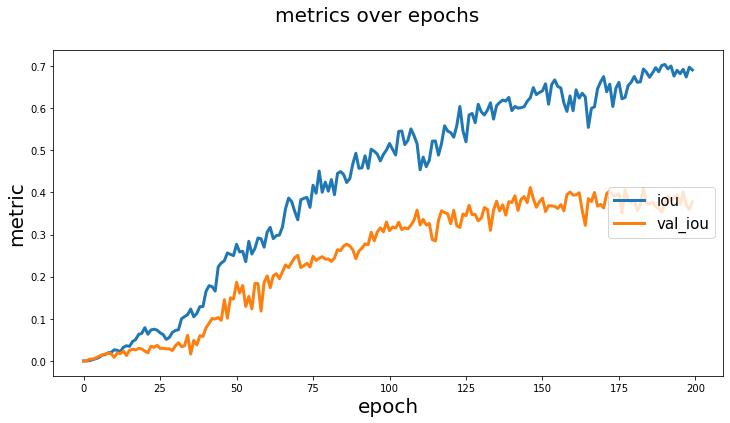

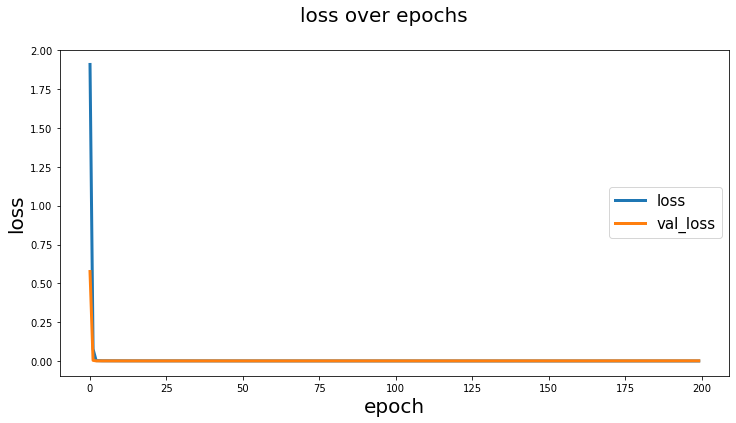

In [42]:
C.Helper.visualize_graph(history)

In [43]:
y_pred = C.Helper.prediction(test_images_array, model)

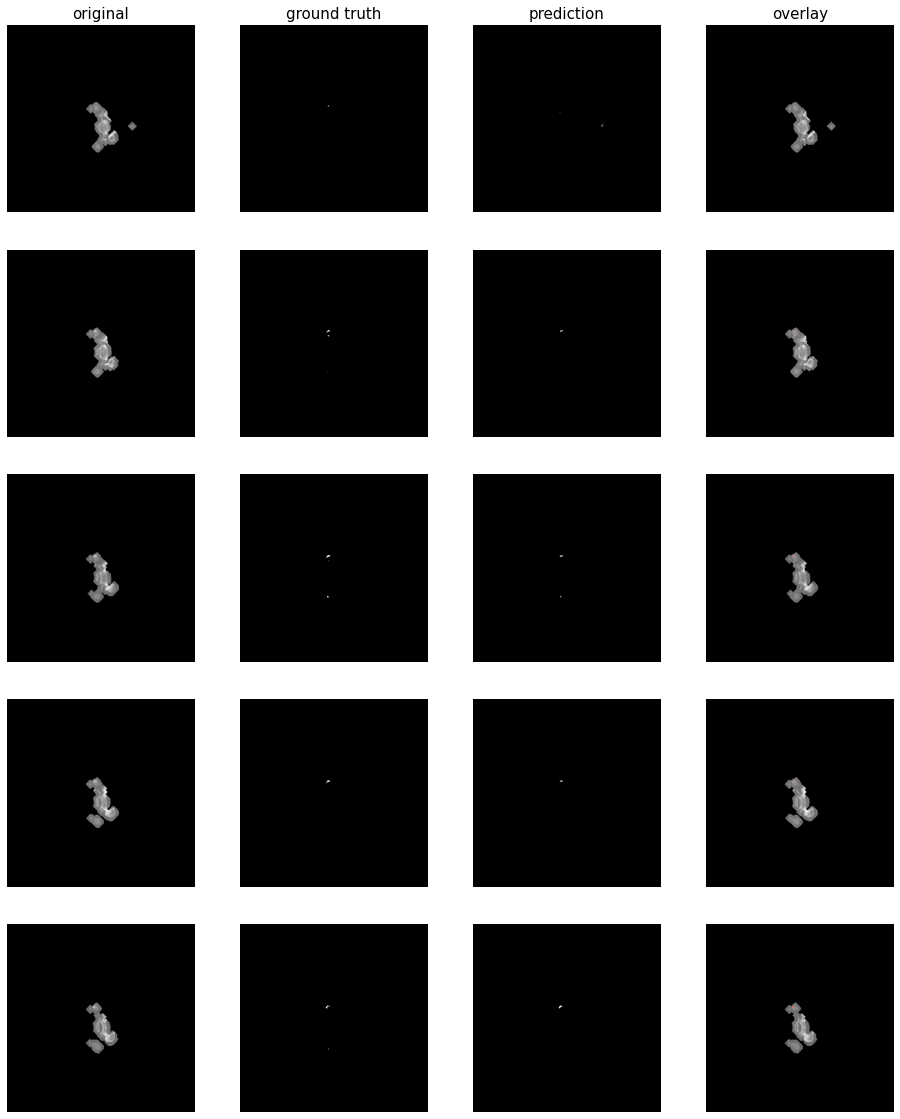

In [44]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [45]:
C.Helper.evaluate(test_images_array, y_test, model)

9/9 [==============================] - 2s 202ms/step - loss: 0.0013 - iou: 0.4721 - iou_thresholded: 0.5093
